# Identifying relationships between annotated omics data in NMDC

In this notebook, we explore how different types of omics data—specifically metagenomic and metatranscriptomic—can be connected through commonly used annotation vocabularies such as biomolecules, taxonomy, and KEGG pathways. Using the **Harvard Forest dataset** as an example, which includes paired and processed metagenomic and metatranscriptomic data available in the NMDC Data Portal, we demonstrate how to link and analyze these data types for integrated interpretation.

In [19]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities
%pip install python-dotenv
%pip install plotly
%pip install kaleido
%pip install scipy

## Set up environment variables
**You can disregard this section of code unless you have interest in testing this on the development API.**

Using pythons python-dotenv package, load the environment variables from the system. This chunk of code is used in the Github CI/CD pipelines to test our development API. The variable can be used when creating `nmdc_api_utilities` objects. If you do not have the environment variable `ENV` set in a .env file, this code with default to the variable "prod" - which tells nmdc_api_utilities to use the production API URL.

In [ ]:
# set up environment variables
from dotenv import load_dotenv
import os
load_dotenv()
# load the environment variable ENV. If it does not exist, default to "prod"
ENV = os.environ.get("ENV", "prod")
SAMPLING_SIZE = os.environ.get("SAMPLING_SIZE", None) # convention: None/0/<0 means "read all"
CACHE_DIR = os.environ.get("CACHE_DIR", "../cached_data")

In [21]:
import requests
import re, sys, io, gzip, json, time, math, hashlib
import pandas as pd
import plotly.express as px, plotly.graph_objects as go
from scipy import stats
import numpy as np
from typing import Dict, List, Optional, Tuple
from io import StringIO
import nmdc_api_utilities

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The [NMDC Data Portal](https://data.microbiomedata.org/) is a powerful resource where you can search for samples by all kinds of criteria. For this example, we’ll focus on finding samples that have both metagenomics and metatranscriptomics data.  
To do this, just use the Data Type filters (the “upset plot” below the interactive map) to quickly spot the right samples. In our case, these filters lead us to samples from the study [“Jeff Blanchard’s Harvard forest soil project”](https://data.microbiomedata.org/details/study/nmdc:sty-11-8ws97026).

### Retrieve and filter data for Harvard forest soil study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-8ws97026`. We will use the [nmdc_api_utilities](https://microbiomedata.github.io/nmdc_api_utilities/) package to access the data_objects/study endpoint from the [NMDC Runtime API](https://api.microbiomedata.org/docs) to retrieve all records that represent data. This includes URLs for downloading raw data files (e.g. FASTQ) as well as processed data results output by the NMDC workflows.

In [22]:
pd.set_option("display.max_rows", 6)
from nmdc_api_utilities.data_object_search import DataObjectSearch
do_client = DataObjectSearch(env=ENV)
#get all data objects associated with this study id
data = do_client.get_data_objects_for_studies(study_id='nmdc:sty-11-8ws97026')
data = pd.DataFrame(data)

#reformat data into dataframe
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = pd.json_normalize(row['data_objects'])
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects).reset_index(drop=True)
display(data_objects)

del data, index, row, row_out, bio_id

,id,type,name,description,data_category,data_object_type,file_size_bytes,md5_checksum,url,was_generated_by,biosample_id
0,nmdc:dobj-11-dmr9gp89,nmdc:DataObject,nmdc_wfmgan-11-fw38xr59.1_gene_phylogeny.tsv,Gene Phylogeny for nmdc:wfmgan-11-fw38xr59.1,processed_data,Gene Phylogeny tsv,1372428284,125dd022c547ddb31b390966c54e75fa,https://data.microbiomedata.org/data/nmdc:dgns...,nmdc:wfmgan-11-fw38xr59.1,nmdc:bsm-11-042nd237
1,nmdc:dobj-11-x77p1a35,nmdc:DataObject,Blanchard_H2Oext_C-7-AB-M_16Feb18_Alder_Infuse...,EnviroMS 12T FT-ICR MS natural organic matter ...,processed_data,Direct Infusion FT-ICR MS Analysis Results,690021,c87550c75a9b959b8d2e79bdbc09dea2,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...,nmdc:wfnom-11-x9tbwk91.1,nmdc:bsm-11-042nd237
2,nmdc:dobj-11-qeabte84,nmdc:DataObject,Blanch_Nat_Pep_C_7_AB_M_07_19Mar18_Oak_18-01-0...,raw instrument file for nmdc:dgms-11-b2e7ph12,instrument_data,LC-DDA-MS/MS Raw Data,2118122650,1ac6141f92873c0f421a71b14e5ce337,https://nmdcdemo.emsl.pnnl.gov/proteomics/raw/...,nmdc:dgms-11-b2e7ph12,nmdc:bsm-11-042nd237
...,...,...,...,...,...,...,...,...,...,...,...
3466,nmdc:dobj-11-wqznfa49,nmdc:DataObject,nmdc_wfmtex-11-ft7zkg91.1_readcount.info,Expression info for nmdc:wfmtex-11-ft7zkg91.1,processed_data,Metatranscriptome Expression Info File,538,1c7ffbbdeb7b36d47b740f66c2718e04,https://data.microbiomedata.org/data/nmdc:dgns...,nmdc:wfmtex-11-ft7zkg91.1,nmdc:bsm-11-y52p4f86
3467,nmdc:dobj-11-y0vctf64,nmdc:DataObject,nmdc_wfmtan-11-c92jzd05.1_cog.gff,COGs for nmdc:wfmtan-11-c92jzd05.1,processed_data,Clusters of Orthologous Groups (COG) Annotatio...,192236633,e25ce09f9f0d8fae66631b84c539ee46,https://data.microbiomedata.org/data/nmdc:dgns...,nmdc:wfmtan-11-c92jzd05.1,nmdc:bsm-11-y52p4f86
3468,nmdc:dobj-11-z5r1tg45,nmdc:DataObject,Blanch_Nat_Lip_H_4_AB_O_06_POS_23Jan18_Brandi-...,Lipid annotations as a result of a lipidomics ...,processed_data,LC-MS Lipidomics Results,35843557,21a6420fad386a8c6d6671c65b84c36b,https://nmdcdemo.emsl.pnnl.gov/lipidomics/blan...,nmdc:wfmb-11-n89m4337.1,nmdc:bsm-11-y52p4f86


One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). 

We want to look at the processed data results for our two omics types of interest in this notebook. Specifically, we want the files containing KEGG Orthology, Taxonomy Lineage, and  Expression data. These expression data is available in file for metatranscriptomics data (in "Metatranscriptome Expression" data object) and annotation data are found together in the metagenomics and metatranscriptomics ( in 'Annotation KEGG Orthology' and 'Gene Phylogeny tsv') results files.

We filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Gene Phylogeny tsv|Tab-delimited file of gene phylogeny|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|Metatranscriptome Expression|Read count table output|


In [23]:
# Filter to biosamples that have KO annotations, Lineage, and expression results
data_objects = data_objects.groupby('biosample_id').filter(lambda x: all(data_type in x['data_object_type'].values for data_type in [
        "Annotation KEGG Orthology",
        "Metatranscriptome Expression",
        "Gene Phylogeny tsv"
    ])).reset_index(drop=True)

# Filter to the desired results file types
results_by_biosample = data_objects[data_objects['data_object_type'].isin([
    "Annotation KEGG Orthology",
    "Metatranscriptome Expression", "Gene Phylogeny tsv"
])][['biosample_id', 'id','data_object_type', 'url']].rename(columns={'id':'output_id'}).reset_index(drop=True)

# Is there one output for each data object type for each biosample?
results_by_biosample['data_object_type'].value_counts().to_frame()

,count
data_object_type,
Gene Phylogeny tsv,64
Annotation KEGG Orthology,64
Metatranscriptome Expression,39


### Select data has both metaT and metaG analysis result
Notice that Each biosample is expected to have two lineage TSV files and two KO results. Therefore, the total count should be double the expression data count (39 × 2 = 78).  However, we only observed 64. This indicates that some biosamples contain only one type of data.  

To address this, we need to filter out those incomplete biosamples and retain only those with both metaG and metaT data for the analysis (n=25).

In [24]:
results_by_biosample["_has_metaT"] = results_by_biosample["url"].str.contains(r"nmdc:wfmt", case=False, na=False)
results_by_biosample["_has_metaG"] = results_by_biosample["url"].str.contains(r"nmdc:wfmg", case=False, na=False)

mask_annotation = results_by_biosample["data_object_type"] == "Annotation KEGG Orthology"
mask_lineage = results_by_biosample["data_object_type"] == "Gene Phylogeny tsv"

results_by_biosample.loc[results_by_biosample["_has_metaT"] & mask_annotation, "data_object_type"] = "MetaT Annotation KEGG Orthology"
results_by_biosample.loc[results_by_biosample["_has_metaG"] & mask_annotation, "data_object_type"] = "MetaG Annotation KEGG Orthology"
results_by_biosample.loc[results_by_biosample["_has_metaT"] & mask_lineage, "data_object_type"] = "MetaT Gene Phylogeny tsv"
results_by_biosample.loc[results_by_biosample["_has_metaG"] & mask_lineage, "data_object_type"] = "MetaG Gene Phylogeny tsv"

# Per-biosample aggregates
agg = results_by_biosample.groupby(results_by_biosample["biosample_id"]).agg(
    rows_per_biosample=("biosample_id", "size"),
    has_metaT=("_has_metaT", "any"),
    has_metaG=("_has_metaG", "any"),
    metaT_row_count=("_has_metaT", "sum"),
    metaG_row_count=("_has_metaG", "sum"),
).reset_index()
# Classify
def classify(row):
    if row["has_metaT"] and row["has_metaG"]:
        return "both_metaT_and_metaG"
    elif row["has_metaT"] and not row["has_metaG"]:
        return "metaT_only"
    elif row["has_metaG"] and not row["has_metaT"]:
        return "metaG_only"
    else:
        return "neither"
agg["category"] = agg.apply(classify, axis=1)



counts = (
    agg["category"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "category", "category": "count"})
)

print(counts)


# Filter to keep only biosamples with both
keep_ids = set(agg.loc[agg["category"] == "both_metaT_and_metaG", "biosample_id"])
drop_ids = set(agg.loc[agg["category"] != "both_metaT_and_metaG", "biosample_id"])
filtered_results_by_biosample = results_by_biosample[results_by_biosample["biosample_id"].isin(keep_ids)].drop(columns=["_has_metaT", "_has_metaG"])
wide = filtered_results_by_biosample.pivot(index="biosample_id", columns="data_object_type", values="url").reset_index()
wide.head(10)

                  count  count
0  both_metaT_and_metaG     25
1            metaT_only     14


data_object_type,biosample_id,MetaG Annotation KEGG Orthology,MetaG Gene Phylogeny tsv,MetaT Annotation KEGG Orthology,MetaT Gene Phylogeny tsv,Metatranscriptome Expression
0,nmdc:bsm-11-042nd237,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
1,nmdc:bsm-11-3p2mnz08,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
2,nmdc:bsm-11-622k6044,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
...,...,...,...,...,...,...
7,nmdc:bsm-11-7m09me46,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
8,nmdc:bsm-11-7twwzs96,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
9,nmdc:bsm-11-8rn9bm20,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...


After filtering out those incomplete biosamples and retaining only those with both metaG and metaT data for the analysis (n=25), we can use `nmdc_api_utilities` to retrieve the associated metadata for these biosamples and these will be used for downstream analysis.

In [25]:
from nmdc_api_utilities.biosample_search import BiosampleSearch

biosample_search = BiosampleSearch(env=ENV)
biosample_records = [biosample_search.get_record_by_id(id_) for id_ in wide['biosample_id'].unique().tolist()]
def extract_value(value):
    if isinstance(value, dict) and 'has_raw_value' in value:
        return value['has_raw_value']
    return value

def biosample_records_to_table(biosample_records):
    rows = []
    for data in biosample_records:
        flat_data = {k: extract_value(v) for k, v in data.items()}
        rows.append(flat_data)
    df = pd.DataFrame(rows).rename(columns={"id":"biosample_id"})
    return df

biosample_metadata = biosample_records_to_table(biosample_records)
display(biosample_metadata)
biosample_metadata.to_csv('biosample_metadata.csv', index=False)

,biosample_id,type,name,associated_studies,env_broad_scale,env_local_scale,env_medium,samp_name,collection_date,depth,...,geo_loc_name,growth_facil,lat_lon,samp_store_temp,specific_ecosystem,store_cond,analysis_type,gold_biosample_identifiers,experimental_factor,sample_link
0,nmdc:bsm-11-042nd237,nmdc:Biosample,BW-C-7-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],forest soil [ENVO:00002261],BW-C-7-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157193, gold:Gb0158505]",NaN,NaN
1,nmdc:bsm-11-3p2mnz08,nmdc:Biosample,Inc-BW-H-2-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-2-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157188],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-127y7152]
2,nmdc:bsm-11-622k6044,nmdc:Biosample,BW-C-12-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],forest soil [ENVO:00002261],BW-C-12-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157185, gold:Gb0158500]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,nmdc:bsm-11-wrvmh591,nmdc:Biosample,Inc-BW-H-32-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-32-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157177],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-k4wb6c34]
23,nmdc:bsm-11-xtz7he28,nmdc:Biosample,Inc-BW-H-17-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-17-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157187],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-fmvr0890]
24,nmdc:bsm-11-xxvfda22,nmdc:Biosample,BW-H-2-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],heat stressed soil [ENVO:00005781],BW-H-2-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157175, gold:Gb0158483]",heat stress treatment [MCO:0000172],NaN


### Download selected results files
 
Now we can use the `url` slots from the filtered `DataObject` records to read in all of the files containing the annotations of interest and stored in a `datastore` data structure.
* datastore['biosample_id']['metag_ko_results']
* datastore['biosample_id']['metat_ko_results'] 
* datastore['biosample_id']['metag_lineage_results']
* datastore['biosample_id']['metat_lineage_results'] 
* datastore['biosample_id']['metat_expression_results'] 

In [26]:
# Ingest into per-sample datastore
ko_columns = ["gene_id", "img_ko_flag", "ko_term", "percent_identity",
              "query_start", "query_end", "subj_start", "subj_end",
              "evalue", "bit_score", "align_length"]
lineage_columns = ["gene_id", "homolog_gene_oid", "homolog_taxon_oid", "percent_identity","lineage"]

subsample_size = SAMPLING_SIZE # convention: None/0/<0 means "read all"

if subsample_size is not None:
    subsample_size = int(subsample_size) if str(subsample_size).isdigit() else None

def get_x_lines(url, num_lines):
    try:
        # Convert to int, handle None/0 as "read all"
        if num_lines is None or num_lines <= 0:
            num_lines = float('inf')  # Read all lines
        else:
            num_lines = int(num_lines)

        # Use stream=True to enable content streaming
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        lines_read = 0
        tab_text = ""
        for line in response.iter_lines(decode_unicode=True):
            # print(line)  # Or process the line as needed
            try:
                line = line.decode("utf-8")
            except (UnicodeDecodeError, AttributeError):
                pass
            tab_text += str(line) + "\n"
            lines_read += 1
            if lines_read >= num_lines:
                break  # Stop after 'num_lines' are read
        return tab_text

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Function to read TSV files
def read_tsv_from_url(url:str, column_names:None, subsample_size=None):
    print(f"Importing data from {url} ... ")
    partial_tab = get_x_lines(url, subsample_size)
    if column_names is None:
        data = pd.read_csv(StringIO(partial_tab), sep='\t')
    else:
        data = pd.read_csv(StringIO(partial_tab), sep='\t', header=None, names=column_names)
    return data


def load_sample_row(row: pd.Series) -> Dict[str, Optional[pd.DataFrame]]:
    col_map = {
        "MetaG Annotation KEGG Orthology": ("metag_ko_results", ko_columns),
        "MetaT Annotation KEGG Orthology": ("metat_ko_results", ko_columns),
        "MetaG Gene Phylogeny tsv": ("metag_lineage_results", lineage_columns),
        "MetaT Gene Phylogeny tsv": ("metat_lineage_results", lineage_columns),
        "Metatranscriptome Expression": ("metat_expression_results", None),
    }

    out = {}
    for col, (key, cols) in col_map.items():
        url = row.get(col, np.nan)
        out[key] = (
            read_tsv_from_url(url, cols, subsample_size=subsample_size)
            if pd.notnull(url)
            else None
        )
    return out


def build_datastore(wide_df: pd.DataFrame) -> Dict[str, Dict[str, Optional[pd.DataFrame]]]:
    store = {}
    for _, row in wide_df.iterrows():
        biosample_id = str(row["biosample_id"])
        store[biosample_id] = load_sample_row(row)
    return store


datastore = build_datastore(wide)
len(datastore)


Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-zayj8368/nmdc:wfmgan-11-fw38xr59.1/nmdc_wfmgan-11-fw38xr59.1_ko.tsv ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_ko.tsv ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-zayj8368/nmdc:wfmgan-11-fw38xr59.1/nmdc_wfmgan-11-fw38xr59.1_gene_phylogeny.tsv ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_gene_phylogeny.tsv ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtex-11-n2w8c804.1/nmdc_wfmtex-11-n2w8c804.1.rnaseq_gea.txt ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-yxhzrq69/nmdc:wfmgan-11-t597cr38.1/nmdc_wfmgan-11-t597cr38.1_ko.tsv ... 
Importing data from https://data.microbiomedata.org/data/nmdc:dgns-11-sfhj5f74/nmdc:wfmtan-11-qn0rff14.1/nmdc_

25

In [27]:
# check total number of biosamples
print("# of biosamples: ", len(datastore))
# View a snippet of the metagenome KEGG Orthology annotations file
datastore[next(iter(datastore))]['metag_ko_results'].head(3)

# of biosamples:  25


,gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
0,nmdc:wfmgan-11-fw38xr59.1_0000001_16096_17001,2574333214,KO:K11936,61.54,1,286,1,283,2.000000e-124,414.0,286
1,nmdc:wfmgan-11-fw38xr59.1_0000001_22302_23399,2524282950,KO:K02335,30.08,14,274,8,239,5.700000e-14,87.1,261
2,nmdc:wfmgan-11-fw38xr59.1_0000001_25193_26839,646747065,KO:K00525,61.61,3,548,18,564,1.500000e-249,796.0,546


## 2. KEGG Orthology (KO) Analysis
### Shared vs unique KOs (MetaG vs MetaT)
 
Metagenomic and metatranscriptome results in NMDC both include KEGG Orthology (KO) annotations. This allows us to compare the shared and unique KOs between the two data types across biosamples.

Technically, we parse the KO TSV files for both MetaG and MetaT, standardize the KO IDs (Kxxxxx format), and calculate the following for each biosample:

 * Number of MetaG KOs (n_metag_ko)
 * Number of MetaT KOs (n_metat_ko)
 * Number of shared KOs (n_shared_ko)
 * Number unique to MetaG (n_metag_only)
 * Number unique to MetaT (n_metat_only)
 * Jaccard index

Additionally, we generate a Plotly stacked bar chart to visualize the comparison of shared and unique KOs for each biosample. We also create a violin plot or stacked bar chart to compare the distribution of shared KOs across different ecosystems.

In [28]:
# 1) Shared/unique KO annotations
OUTPUT_DIR=os.getcwd()  # specify your desired output directory here
def extract_ko_id(x: Optional[str]) -> Optional[str]:
    if not isinstance(x, str):
        return None
    m = re.search(r"K\d{5}", x.upper())
    return m.group(0) if m else None
def standardize_ko_df(df_ko: pd.DataFrame) -> pd.DataFrame:
    if df_ko is None or len(df_ko) == 0:
        return pd.DataFrame(columns=["gene_id", "ko_id", "ko_term"])
    for needed in ["gene_id", "ko_term"]:
        if needed not in df_ko.columns:
            raise ValueError(f"KO file missing required column: {needed}.")
    out = df_ko.copy()
    out["ko_id"] = out["ko_term"].map(extract_ko_id)
    out = out.dropna(subset=["ko_id"]).copy()
    out["gene_id"] = out["gene_id"].astype(str)
    return out[["gene_id", "ko_id", "ko_term"]].drop_duplicates()

def shared_ko_stats_per_sample(datastore):
    rows = []
    for biosample_id, items in datastore.items():
        metag = standardize_ko_df(items.get("metag_ko_results"))
        metat = standardize_ko_df(items.get("metat_ko_results"))
        mg = set(metag["ko_id"].dropna().unique())
        mt = set(metat["ko_id"].dropna().unique())
        shared = mg & mt
        rows.append({
            "biosample_id": biosample_id,
            "n_metag_ko": len(mg),
            "n_metat_ko": len(mt),
            "n_shared_ko": len(shared),
            "n_metag_only": len(mg - mt),
            "n_metat_only": len(mt - mg),
            "jaccard": (len(shared)/len(mg|mt)) if (mg or mt) else float("nan"),
        })
    return pd.DataFrame(rows)

ko_overlap_df = shared_ko_stats_per_sample(datastore)
ko_overlap_df.to_csv(os.path.join(OUTPUT_DIR, "ko_overlap_summary.csv"), index=False)
ko_overlap_df.head(20)

,biosample_id,n_metag_ko,n_metat_ko,n_shared_ko,n_metag_only,n_metat_only,jaccard
0,nmdc:bsm-11-042nd237,2758,1745,1286,1472,459,0.399751
1,nmdc:bsm-11-3p2mnz08,2693,1514,1178,1515,336,0.388907
2,nmdc:bsm-11-622k6044,2386,1450,1060,1326,390,0.381844
...,...,...,...,...,...,...,...
17,nmdc:bsm-11-hebdaz02,2626,1922,1378,1248,544,0.434700
18,nmdc:bsm-11-ncyddq48,2855,1997,1376,1479,621,0.395857
19,nmdc:bsm-11-nq2tfm26,2693,1796,1468,1225,328,0.485932


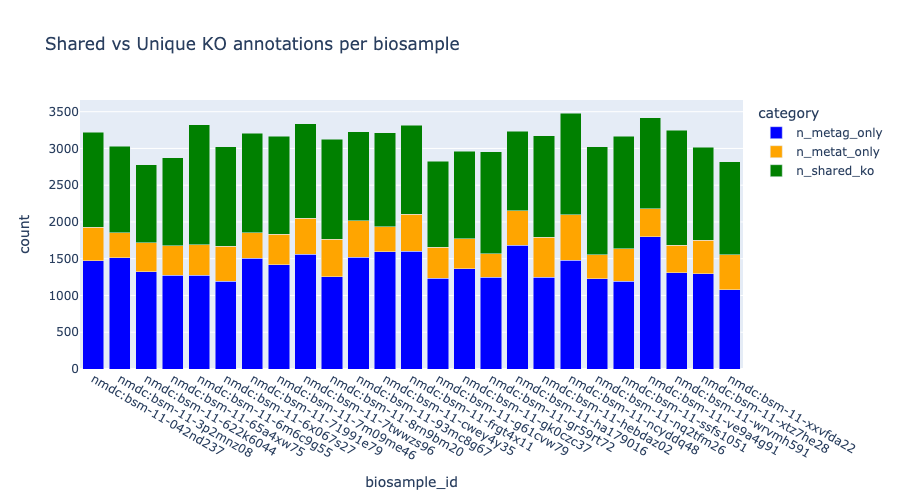

In [29]:
# Plot: stacked bar chart shared vs unique
if len(ko_overlap_df):
    df_long = ko_overlap_df.melt(id_vars=["biosample_id"], value_vars=["n_metag_only", "n_metat_only", "n_shared_ko"],
                                 var_name="category", value_name="count")
    fig = px.bar(df_long, x="biosample_id", y="count", color="category", color_discrete_map={
        "n_metag_only": "blue",
        "n_metat_only": "orange",
        "n_shared_ko": "green"
    }, barmode="stack",
                 title="Shared vs Unique KO annotations per biosample")
    fig.write_html(os.path.join(OUTPUT_DIR, "plot_shared_ko_barchart.html"), include_plotlyjs="cdn", full_html=True)
fig.show(renderer="png",width=900) if len(ko_overlap_df) else None


This figure indicates that a substantial portion of the metagenomic functional potential is actively expressed, while the metagenome also contains many KOs with no corresponding transcripts (possibly dormant or low-expression genes). Likewise, a number of KOs appear only in the metatranscriptome, which could arise from highly expressed genes of low abundance organisms or unassembled genomic fragments. Some “metatranscriptome-only KOs” could actually be present in DNA but missing from metagenomic assemblies due to coverage gaps, strain variation, or assembly fragmentation.

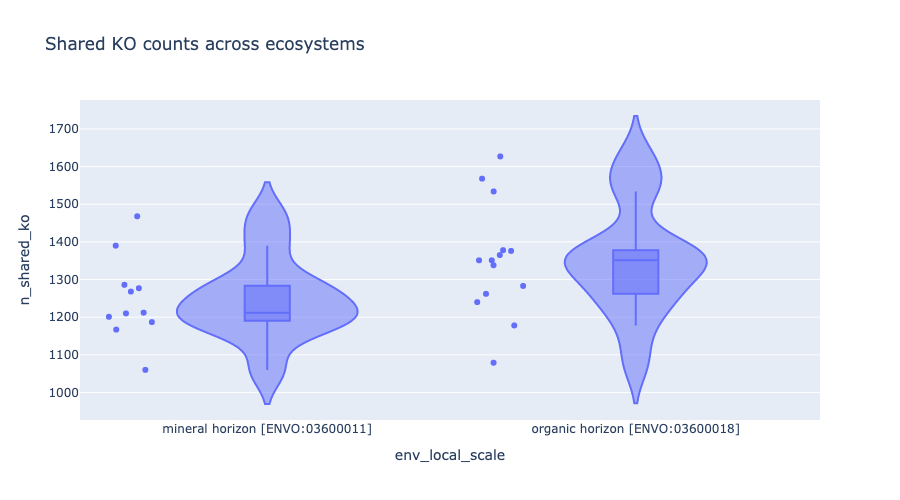

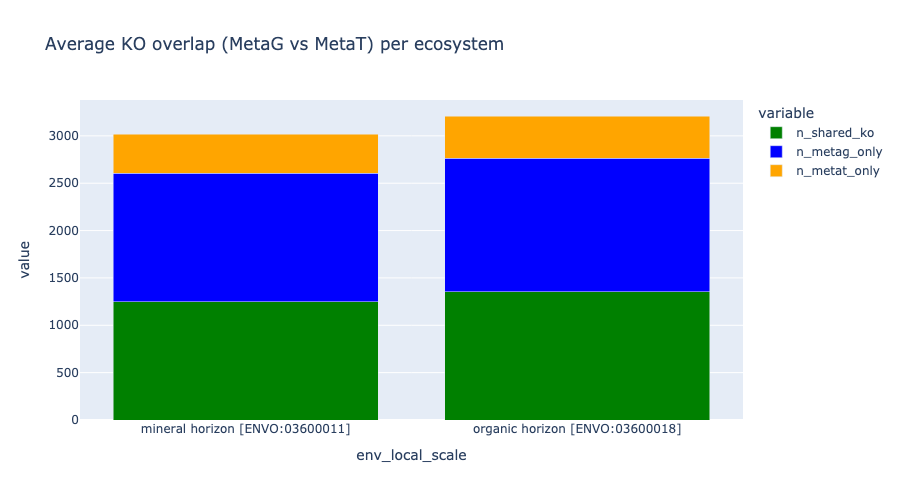

In [30]:
ko_with_meta = ko_overlap_df.merge(biosample_metadata[["biosample_id", "env_local_scale"]], on="biosample_id", how="left")
# KO overlap differences across ecosystems
if len(ko_with_meta):
    fig = px.violin(ko_with_meta, x="env_local_scale", y="n_shared_ko", box=True, points="all",
                    title="Shared KO counts across ecosystems")
    fig.show(renderer="png",width=900)

    eco_summary = (ko_with_meta.groupby("env_local_scale")[["n_shared_ko","n_metag_only","n_metat_only"]]
                   .mean().reset_index())
    fig2 = px.bar(eco_summary.melt(id_vars="env_local_scale", 
                                   value_vars=["n_shared_ko","n_metag_only","n_metat_only"]),
                  x="env_local_scale", y="value", color="variable", barmode="stack", color_discrete_map={
                    "n_shared_ko": "green",
                    "n_metag_only": "blue",
                    "n_metat_only": "orange"
                  },
                  title="Average KO overlap (MetaG vs MetaT) per ecosystem")
    fig2.show(renderer="png",width=900)

Violin plot of shared KO counts across ecosystems shows the distribution of the number of shared KOs (MetaG ∩ MetaT) for each biosample within ecosystems.

* Functional overlap between potential (DNA) and activity (RNA) is relatively consistent across ecosystems, but variability is greater in mineral horizon, perhaps reflecting more heterogeneous communities or microenvironments.
* With slightly higher shared KO counts on average, organic horizon may support more consistently active functional repertoires due to richer nutrient availability and microbial activity.

Stacked bar chart of average KO categories per ecosystem

* Both ecosystems show a strong backbone of shared functions.
* Mineral horizon → bias toward transcriptome-only functions (active niche-specialized expression).
* Organic horizon → bias toward metagenome-only functions (large reservoir of potential functions not currently expressed).


## 3. KEGG Pathway Analysis

Next, we use the KEGG API to look up KO annotations and determine their corresponding pathways in KEGG.

We calcudate KEGG pathway coverage & expression across biosamples:

* Aggregate MetaT expression data at the pathway level and summarize coverage for each pathway and sample:

	* Number of MetaG KOs (n_metag_kos)
	* Number of MetaT KOs (n_metat_kos)
	* Number of shared KOs (n_shared_kos)

* Aggregate by biosamples to compare the KO count per pathway among shared, metag_only, metat_only and env_local_scale. 

* Generate Plotly heatmaps to visualize:

    * Pathway expression (log1p-transformed expression values) by env_local_scale
	* Pathway coverage (counts of shared or modality-specific KOs) by env_local_scale

* Statistics across biosamples and pathways:

	* Perform non-parametric Kruskal–Wallis testing to compare pathway expression distributions across biosamples, with Benjamini–Hochberg FDR correction.

* Visualize top pathways by expression using Plotly violin or box plots.

In [31]:

# KEGG pathway mapping & coverage / expression
RUN_KEGG_MAPPING=True
CACHE_DIR=os.getcwd() 
def kegg_link_ko_to_pathways(ko_ids: List[str]) -> pd.DataFrame:
    ko_ids = sorted(set([k for k in ko_ids if isinstance(k, str) and re.match(r"K\d{5}", k)]))
    if not ko_ids:
        return pd.DataFrame(columns=["ko_id", "pathway_id"])
    cache_map_path = os.path.join(CACHE_DIR, "kegg_ko_pathway_map.tsv")
    cached = pd.read_csv(cache_map_path, sep="\t", dtype=str) if os.path.exists(cache_map_path) else pd.DataFrame(columns=["ko_id", "pathway_id"])
    cached_set = set(map(tuple, cached[["ko_id","pathway_id"]].dropna().itertuples(index=False, name=None)))
    missing = []
    for k in ko_ids:
        if not any(row[0]==k for row in cached_set): missing.append(k)
    new_rows = []
    if RUN_KEGG_MAPPING and missing:
        import requests
        for k in missing:
            try:
                url = f"https://rest.kegg.jp/link/pathway/ko:{k}"
                resp = requests.get(url, timeout=30)
                if resp.status_code==200:
                    for line in resp.text.strip().splitlines():
                        parts=line.split("\t")
                        if len(parts)==2:
                            ko_part = parts[0].split(":")[-1].strip().upper()
                            path_part = parts[1].split(":")[-1].strip()
                            new_rows.append((ko_part, path_part))
            except Exception as e:
                print("[KEGG] error", k, e)
        if new_rows:
            add_df = pd.DataFrame(new_rows, columns=["ko_id","pathway_id"])
            cached = pd.concat([cached, add_df], ignore_index=True).drop_duplicates()
            cached.to_csv(cache_map_path, sep="\t", index=False)
    return cached[cached["ko_id"].isin(ko_ids)].drop_duplicates()

def kegg_pathway_names(pathway_ids: List[str]) -> pd.DataFrame:
    pathway_ids = sorted(set([p for p in pathway_ids if isinstance(p, str) and re.match(r"map\d{5}", p)]))
    if not pathway_ids:
        return pd.DataFrame(columns=["pathway_id","pathway_name"])
    cache_names_path = os.path.join(CACHE_DIR, "kegg_pathway_names.tsv")
    cached = pd.read_csv(cache_names_path, sep="\t", dtype=str) if os.path.exists(cache_names_path) else pd.DataFrame(columns=["pathway_id","pathway_name"])
    cached_dict = dict(zip(cached["pathway_id"], cached["pathway_name"]))
    missing = [p for p in pathway_ids if p not in cached_dict]
    new_rows = []
    if RUN_KEGG_MAPPING and missing:
        import requests
        for p in missing:
            try:
                url = f"https://rest.kegg.jp/list/{p}"
                resp = requests.get(url, timeout=30)
                if resp.status_code==200:
                    first = resp.text.strip().splitlines()[0]
                    parts = first.split("\t")
                    if len(parts)==2:
                        new_rows.append((p, parts[1]))
            except Exception as e:
                print("[KEGG] name error", p, e)
        if new_rows:
            add_df = pd.DataFrame(new_rows, columns=["pathway_id","pathway_name"])
            cached = pd.concat([cached, add_df], ignore_index=True).drop_duplicates()
            cached.to_csv(cache_names_path, sep="\t", index=False)
    return cached[cached["pathway_id"].isin(pathway_ids)].drop_duplicates()

def build_ko_to_pathway_mapping(datastore):
    all_kos = set()
    for items in datastore.values():
        for key in ["metag_ko_results","metat_ko_results"]:
            dfk = standardize_ko_df(items.get(key))
            all_kos.update(dfk["ko_id"].dropna().unique().tolist())
    all_kos = sorted(all_kos)
    if not all_kos: return pd.DataFrame(columns=["ko_id","pathway_id","pathway_name"])
    ko2path = kegg_link_ko_to_pathways(all_kos)
    path_names = kegg_pathway_names(ko2path["pathway_id"].unique().tolist()) if len(ko2path) else pd.DataFrame(columns=["pathway_id","pathway_name"])
    return ko2path.merge(path_names, on="pathway_id", how="left")

ko_path_map = build_ko_to_pathway_mapping(datastore)
ko_path_map.head(10)


,ko_id,pathway_id,pathway_name
0,K00844,map00521,Streptomycin biosynthesis [PATH:ko00521]
1,K00844,map00500,Starch and sucrose metabolism [PATH:ko00500]
2,K00844,map04066,HIF-1 signaling pathway [PATH:ko04066]
...,...,...,...
7,K00844,map05230,Central carbon metabolism in cancer [PATH:ko05...
8,K00844,map00051,Fructose and mannose metabolism [PATH:ko00051]
9,K00844,map00010,Glycolysis / Gluconeogenesis [PATH:ko00010]


In [32]:
# Aggregate MetaT expression data at the pathway level and summarize coverage for each pathway and sample of metaT and metaG
def parse_expression_df(df_expr: pd.DataFrame) -> pd.DataFrame:
    gene_col = "img_gene_oid"
    expr_col = "reads_cnt"
    OUT_gene_col = "gene_id"
    OUT_expr_col = "expr_value"

    if df_expr is None or len(df_expr) == 0:
        return pd.DataFrame(columns=[OUT_gene_col, OUT_expr_col])
    df = df_expr.copy()
    
    out = df[[gene_col, expr_col]].copy()
    out.columns = [OUT_gene_col, OUT_expr_col]
    out[OUT_expr_col] = pd.to_numeric(out[OUT_expr_col], errors="coerce")
    out = out.dropna(subset=[OUT_gene_col]).copy()
    out[OUT_gene_col] = out[OUT_gene_col].astype(str)
    out = out.groupby(OUT_gene_col, as_index=False)[OUT_expr_col].sum()
    return out

def compute_pathway_expression_coverage(datastore, ko_path_map):
    rows_expr, rows_presence = [], []
    for biosample_id, items in datastore.items():
        metag = standardize_ko_df(items.get("metag_ko_results"))
        metat = standardize_ko_df(items.get("metat_ko_results"))
        expr  = parse_expression_df(items.get("metat_expression_results"))
        if len(metat) and len(expr):
            metat_expr = metat.merge(expr, left_on="gene_id", right_on="gene_id", how="left")
        else:
            metat_expr = pd.DataFrame(columns=["gene_id","ko_id","ko_term","expr_value"])

        if len(ko_path_map)==0: continue

        mg_kos = set(metag["ko_id"].unique().tolist())
        mt_kos = set(metat["ko_id"].unique().tolist())
        sh_kos = mg_kos & mt_kos

        for path_id, sub in ko_path_map.groupby("pathway_id"):
            p_name = sub["pathway_name"].dropna().iloc[0] if "pathway_name" in sub.columns and sub["pathway_name"].notna().any() else path_id
            path_kos = set(sub["ko_id"].unique().tolist())
            rows_presence.append({
                "biosample_id": biosample_id,
                "pathway_id": path_id, "pathway_name": p_name,
                "n_metag_kos": len(path_kos & mg_kos),
                "n_metat_kos": len(path_kos & mt_kos),
                "n_shared_kos": len(path_kos & sh_kos),
            })

        if len(metat_expr):
            metat_expr_by_ko = metat_expr.groupby("ko_id", as_index=False)["expr_value"].sum()
            joined = metat_expr_by_ko.merge(ko_path_map[["ko_id","pathway_id","pathway_name"]].drop_duplicates(),
                                            on="ko_id", how="left")
            grouped = joined.groupby(["pathway_id","pathway_name"], as_index=False)["expr_value"].sum()
            for _, r in grouped.iterrows():
                rows_expr.append({
                    "biosample_id": biosample_id,
                    "pathway_id": r["pathway_id"],
                    "pathway_name": r["pathway_name"],
                    "expr_sum": float(r["expr_value"]),
                })
    return pd.DataFrame(rows_expr), pd.DataFrame(rows_presence)

pathway_expr, pathway_presence = compute_pathway_expression_coverage(datastore, ko_path_map)
pathway_expr.to_csv(os.path.join(OUTPUT_DIR, "pathway_expression_by_sample.csv"), index=False)
pathway_presence.to_csv(os.path.join(OUTPUT_DIR, "pathway_presence_by_sample.csv"), index=False)
(pathway_expr.head(10), pathway_presence.head(10))


(            biosample_id pathway_id  \
 0   nmdc:bsm-11-042nd237   map00010   
 1   nmdc:bsm-11-042nd237   map00020   
 2   nmdc:bsm-11-042nd237   map00030   
 ..                   ...        ...   
 7   nmdc:bsm-11-042nd237   map00061   
 8   nmdc:bsm-11-042nd237   map00071   
 9   nmdc:bsm-11-042nd237   map00073   
 
                                          pathway_name  expr_sum  
 0         Glycolysis / Gluconeogenesis [PATH:ko00010]   13157.0  
 1            Citrate cycle (TCA cycle) [PATH:ko00020]   11092.0  
 2            Pentose phosphate pathway [PATH:ko00030]    8943.0  
 ..                                                ...       ...  
 7              Fatty acid biosynthesis [PATH:ko00061]    3676.0  
 8               Fatty acid degradation [PATH:ko00071]    3740.0  
 9   Cutin, suberine and wax biosynthesis [PATH:ko0...       0.0  
 
 [10 rows x 4 columns],
             biosample_id pathway_id  \
 0   nmdc:bsm-11-042nd237   map00010   
 1   nmdc:bsm-11-042nd237   map00020

In [33]:
# Merge metadata
pathway_presence = pathway_presence.merge(
    biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left"
)

# Compute modality-specific counts
pathway_presence["n_metag_only"] = (pathway_presence["n_metag_kos"] - pathway_presence["n_shared_kos"]).clip(lower=0)
pathway_presence["n_metat_only"] = (pathway_presence["n_metat_kos"] - pathway_presence["n_shared_kos"]).clip(lower=0)

# Aggregate by ecosystem × pathway
eco_pathway = (
    pathway_presence
    .groupby(["env_local_scale","pathway_name"], as_index=False)
    [["n_metag_only","n_metat_only","n_shared_kos"]]
    .mean()
)

eco_pathway.to_csv(os.path.join(OUTPUT_DIR, "pathway_coverage_by_ecosystem.csv"), index=False)
eco_pathway.head()

,env_local_scale,pathway_name,n_metag_only,n_metat_only,n_shared_kos
0,mineral horizon [ENVO:03600011],ABC transporters [PATH:ko02010],47.181818,32.909091,33.181818
1,mineral horizon [ENVO:03600011],AGE-RAGE signaling pathway in diabetic complic...,0.272727,1.818182,0.000000
2,mineral horizon [ENVO:03600011],AMPK signaling pathway [PATH:ko04152],1.545455,2.181818,2.000000
3,mineral horizon [ENVO:03600011],ATP-dependent chromatin remodeling [PATH:ko03082],0.000000,0.909091,0.000000
4,mineral horizon [ENVO:03600011],Acarbose and validamycin biosynthesis [PATH:ko...,1.363636,0.000000,1.454545


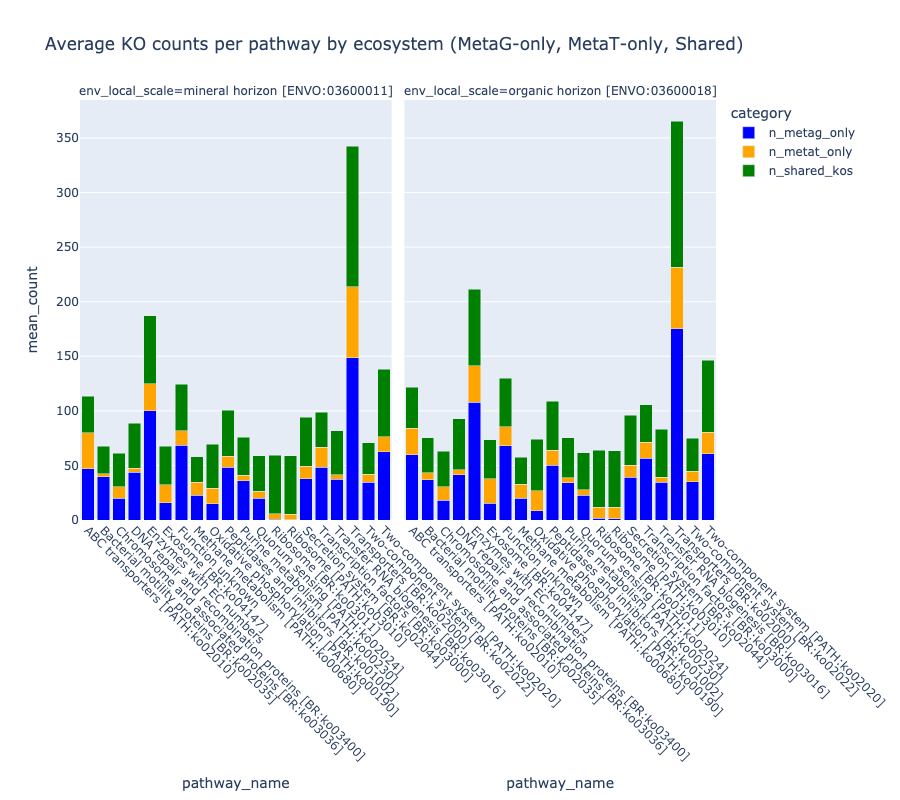

In [34]:
## Now visualize pathway coverage across ecosystems by category

dfm = eco_pathway.melt(
    id_vars=["env_local_scale","pathway_name"],
    value_vars=["n_metag_only","n_metat_only","n_shared_kos"],
    var_name="category", value_name="mean_count"
)

# Show top 20 pathways by total KO count across ecosystems
top_paths = (
    dfm.groupby("pathway_name")["mean_count"].sum()
    .sort_values(ascending=False).head(20).index
)
dfm_top = dfm[dfm["pathway_name"].isin(top_paths)]

fig = px.bar(
    dfm_top, x="pathway_name", y="mean_count", color="category", color_discrete_map={
        "n_metag_only": "blue",
        "n_metat_only": "orange",
        "n_shared_kos": "green"
    },
    facet_col="env_local_scale", barmode="stack",
    title="Average KO counts per pathway by ecosystem (MetaG-only, MetaT-only, Shared)"
)
fig.update_xaxes(tickangle=45)
fig.write_html(os.path.join(OUTPUT_DIR, "ecosystem_pathway_counts_barchart.html"),
               include_plotlyjs="cdn", full_html=True)
fig.show(renderer="png",width=900, height=800)

* Both ecosystems share a backbone of pathways dominated by shared KOs (green), especially in broad metabolic categories like **Transporters**, **Ribosome biogenesis**, **Membrane trafficking**.
* Mineral horizon seem to have relatively more MetaT-only KOs (orange), while Organic horizon show more MetaG-only KOs (blue) which is agreed with previous after breakdown to pathways.

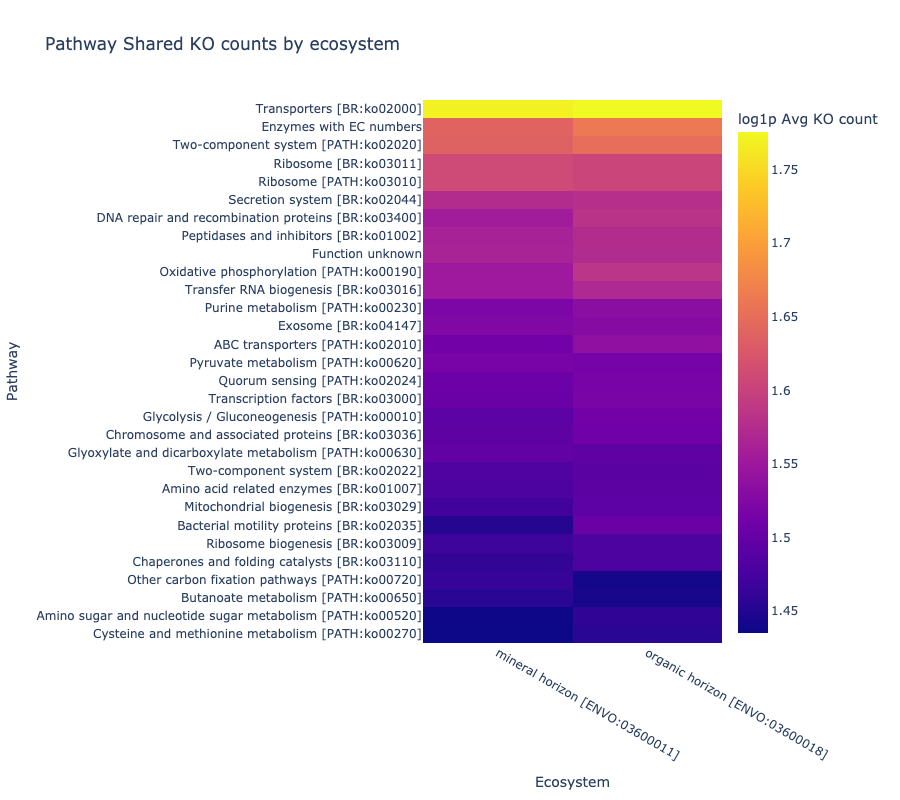

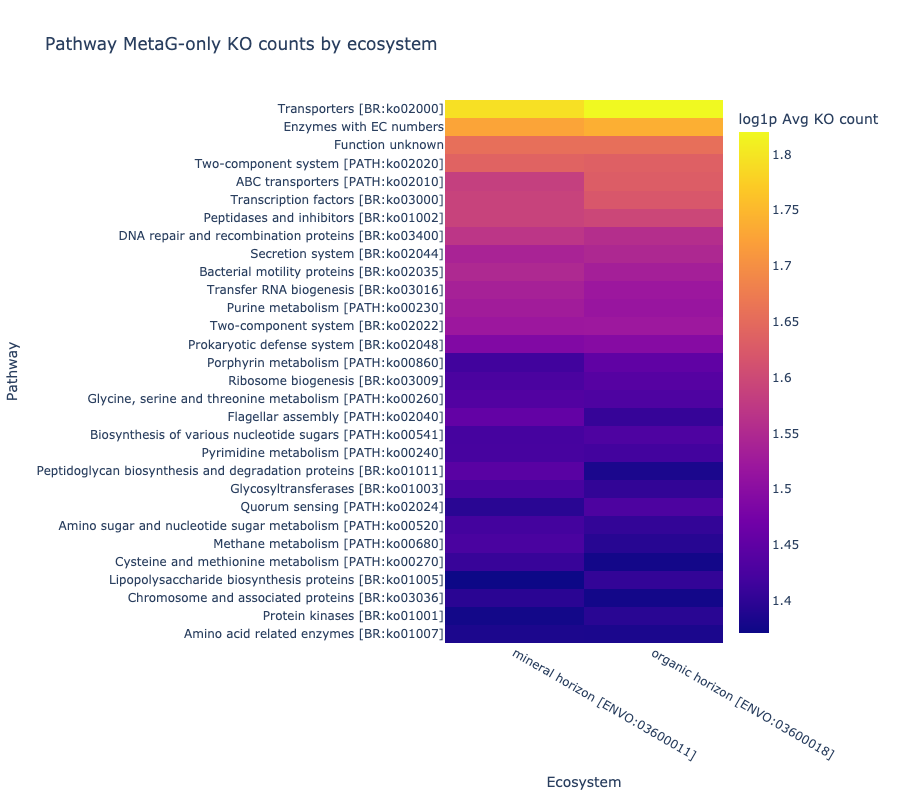

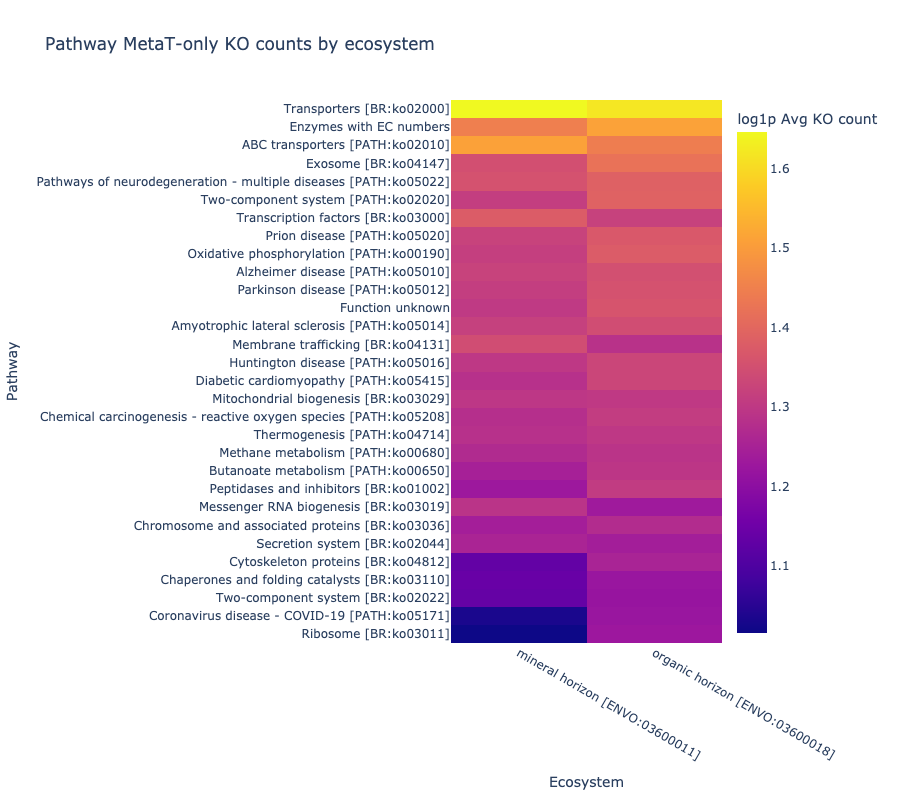

In [35]:
# Now visualize heatmaps of pathways by ecosystem and category

for cat, label in {
    "n_shared_kos": "Shared KO counts",
    "n_metag_only": "MetaG-only KO counts",
    "n_metat_only": "MetaT-only KO counts"
}.items():
    eco_pathway['log1p_cat'] = np.log1p(eco_pathway[cat])
    mat = eco_pathway.pivot(index="pathway_name", columns="env_local_scale", values='log1p_cat').fillna(0)
    order = mat.sum(axis=1).sort_values(ascending=False).head(30).index  # show top 30 pathways
    mat = mat.loc[order]
    mat_log = np.log1p(mat)
    fig = px.imshow(mat_log, labels=dict(x="Ecosystem", y="Pathway", color="log1p Avg KO count"), aspect='auto',
                    title=f"Pathway {label} by ecosystem")
    out_html = os.path.join(OUTPUT_DIR, f"ecosystem_pathway_heatmap_{cat}.html")
    fig.write_html(out_html, include_plotlyjs="cdn", full_html=True)
    fig.show(renderer="png",width=900, height=800)

### Pathway shared KO counts by env_local_scale 
* Shared KOs represent the core functional repertoire that is both present and actively expressed in both ecosystems.
* Ecosystem differences are relatively modest here → core microbial metabolism is stable across soil horizons.

### Pathway MetaG-only KO counts by env_local_scale 
* Organic horizon contain a larger genomic reservoir of unexpressed functions — microbes may be carrying genes for future metabolic flexibility, but not currently expressing them.
* This aligns with the nutrient-rich nature of organic horizons, where microbial genomes may be more diverse but expression is tuned to immediate needs.

### Pathway MetaT-only KO counts by env_local_scale
* Mineral horizon contain more transcriptional activity from functions not well captured in metagenomic assemblies.



In [36]:
# Merge metadata
pathway_expr_meta = pathway_expr.merge(
    biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left"
)
# Aggregate by ecosystem × pathway
eco_pathway_expr = (
    pathway_expr_meta
    .groupby(["env_local_scale","pathway_name","pathway_id"], as_index=False)
    [["expr_sum"]]
    .mean()
)

eco_pathway_expr.to_csv(os.path.join(OUTPUT_DIR, "pathway_expr_by_ecosystem.csv"), index=False)
eco_pathway_expr.head()

,env_local_scale,pathway_name,pathway_id,expr_sum
0,mineral horizon [ENVO:03600011],ABC transporters [PATH:ko02010],map02010,8243.727273
1,mineral horizon [ENVO:03600011],AGE-RAGE signaling pathway in diabetic complic...,map04933,242.857143
2,mineral horizon [ENVO:03600011],AMPK signaling pathway [PATH:ko04152],map04152,654.454545
3,mineral horizon [ENVO:03600011],ATP-dependent chromatin remodeling [PATH:ko03082],map03082,274.777778
4,mineral horizon [ENVO:03600011],Acarbose and validamycin biosynthesis [PATH:ko...,map00525,73.100000


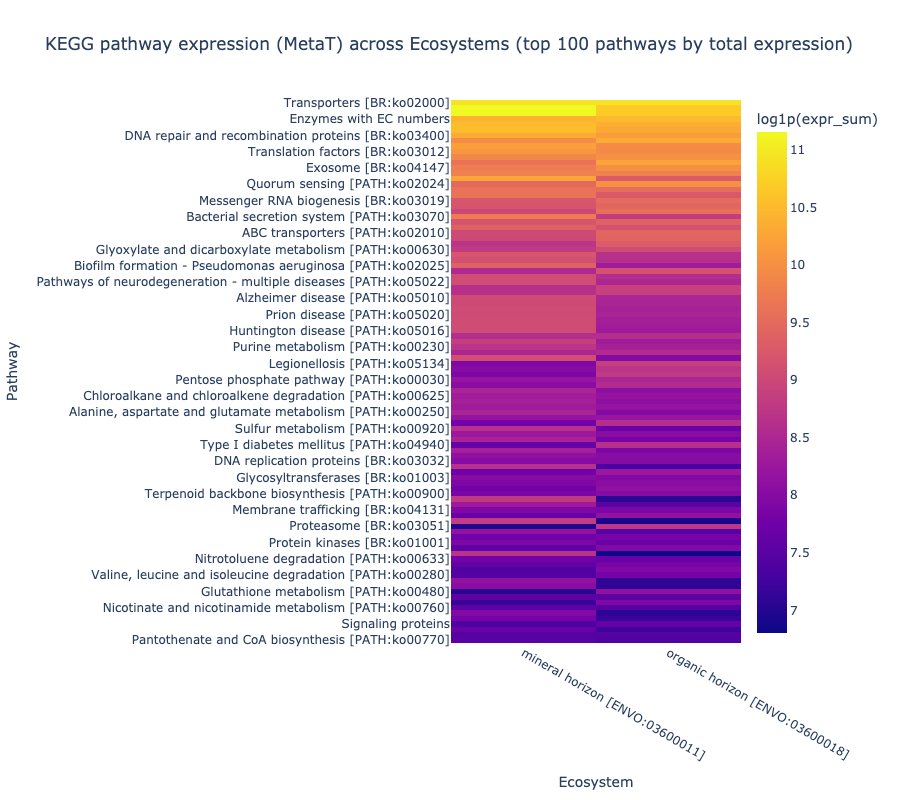

In [37]:
#Now visualize heatmap of pathway expression across ecosystems

if len(pathway_expr):
    mat = eco_pathway_expr.copy()
    mat["log_expr"] = np.log1p(mat["expr_sum"].astype(float))
    heat = mat.pivot_table(index="pathway_name", columns="env_local_scale", values="log_expr", fill_value=0.0).sort_index()
    # Sort pathway by sum of log_expr across all ecosystems (descending)
    pathway_order = heat.sum(axis=1).sort_values(ascending=False).index
    heat = heat.loc[pathway_order]
    fig = px.imshow(heat[:100], labels=dict(x="Ecosystem", y="Pathway", color="log1p(expr_sum)"),aspect='auto',
                    title="KEGG pathway expression (MetaT) across Ecosystems (top 100 pathways by total expression)")
    fig.write_html(os.path.join(OUTPUT_DIR, "heatmap_pathway_expression.html"), include_plotlyjs="cdn", full_html=True)
    fig.show(renderer="png",width=900, height=800)  # use renderer="png" to show in some environments
else:
    None


* The highest-expressed pathways across both mineral and organic horizon are Transporters, Ribosome, Chaperones & folding catalysts, Two-component systems, DNA repair/recombination, and Peptidases.
* Expression intensity patterns look broadly similar between mineral and organic horizon, with only subtle differences in magnitude.
* The similarity between ecosystems suggests a conserved core of functional activity despite environmental differences — basic cellular and stress-response processes are strongly expressed everywhere.


In [38]:
# Statistics: Kruskal–Wallis across biosample (per pathway)
def kruskal_wallis_across_samples(pathway_expr: pd.DataFrame) -> pd.DataFrame:
    if pathway_expr is None or len(pathway_expr) == 0:
        return pd.DataFrame(columns=["pathway_id","pathway_name","p_value","q_value","n_samples"])
    results = []
    for path_id, grp in pathway_expr.groupby("pathway_id"):
        vectors = [sub["expr_sum"].astype(float).values for _, sub in grp.groupby("biosample_id")]
        if len(vectors) >= 2 and all(len(v) > 0 for v in vectors):
            try:
                stat, p = stats.kruskal(*vectors)
            except Exception:
                p = np.nan
            results.append((path_id, grp["pathway_name"].dropna().iloc[0], p, len(vectors)))
    res_df = pd.DataFrame(results, columns=["pathway_id","pathway_name","p_value","n_samples"]).sort_values("p_value")
    m = res_df["p_value"].notna().sum()
    if m>0:
        ranks = res_df["p_value"].rank(method="first")
        res_df["q_value"] = res_df["p_value"] * m / ranks
        res_df["q_value"] = res_df["q_value"].clip(upper=1.0)
    else:
        res_df["q_value"] = np.nan
    return res_df.sort_values("q_value", na_position="last")

kw_df = kruskal_wallis_across_samples(pathway_expr)
kw_df.to_csv(os.path.join(OUTPUT_DIR, "stats_kruskal_pathways_across_biosample.csv"), index=False)
kw_df.head(20)


,pathway_id,pathway_name,p_value,n_samples,q_value
491,map99986,Glycan metabolism,0.460771,24,0.460771
477,map05416,Viral myocarditis [PATH:ko05416],0.460771,24,0.461717
496,map99994,Others,0.460771,24,0.462667
...,...,...,...,...,...
366,map04919,Thyroid hormone signaling pathway [PATH:ko04919],0.460771,24,0.477402
138,map00966,Glucosinolate biosynthesis [PATH:ko00966],0.460771,24,0.478417
59,map00510,N-Glycan biosynthesis [PATH:ko00510],0.460771,24,0.479438


* There is no significant difference in the number KO expression value of metatranscriptomes across the biosamples analyzed (Kruskal-Wallis p > 0.05).

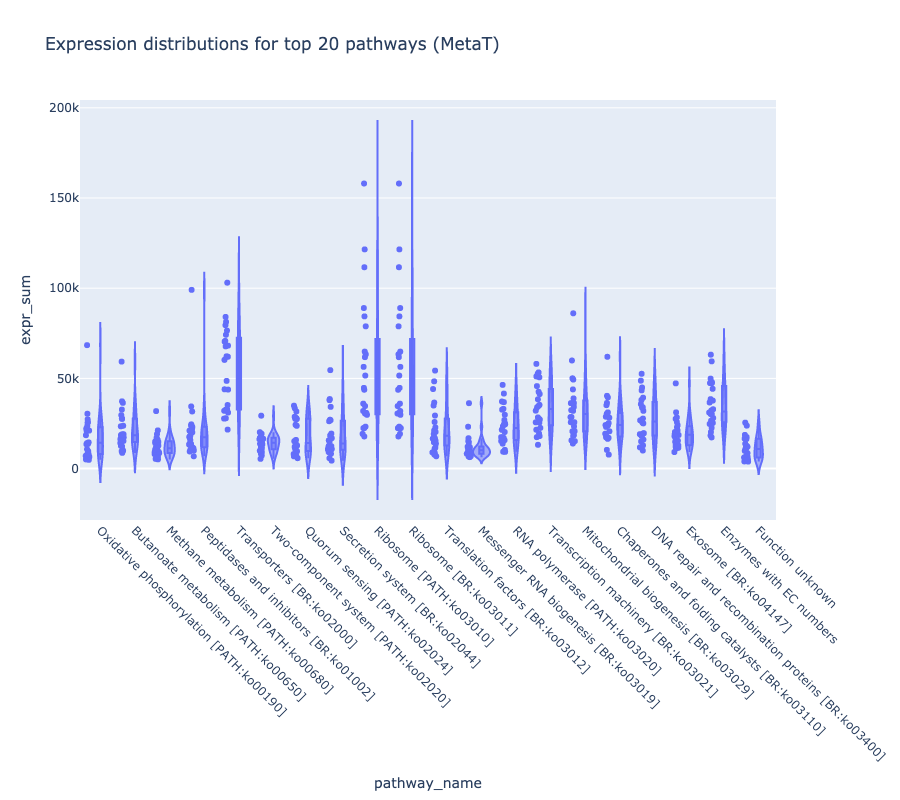

In [39]:
# Violin/Box for top pathways
if len(pathway_expr):
    ranks = (pathway_expr.groupby(["pathway_id","pathway_name"])["expr_sum"]
             .sum().sort_values(ascending=False).head(20).reset_index())
    top_ids = set(ranks["pathway_id"].tolist())
    sub = pathway_expr[pathway_expr["pathway_id"].isin(top_ids)].copy()
    fig = px.violin(sub, x="pathway_name", y="expr_sum", box=True,
                    title="Expression distributions for top 20 pathways (MetaT)", points="all")
    fig.update_xaxes(tickangle=45)
    fig.write_html(os.path.join(OUTPUT_DIR, "violin_top_pathways.html"), include_plotlyjs="cdn", full_html=True)
    fig.show(renderer="png",width=900,height=800)
else:
    None



* Expression is highly skewed: a few pathways (e.g., Transporters, Ribosome, Transcription machinery) show very wide distributions, with some biosamples having extremely high expression.
* Other pathways (e.g., DNA repair, Chaperones, Exosome) show more compact distributions, suggesting consistent expression across biosamples.
* Expression variability is highest in pathways linked to environmental interactions (e.g., transporters, sensing systems), suggesting these are key levers of ecological adaptation in soils.

## 4. Taxonomy comparison: MetaG lineage vs MetaT lineage + expression

Here we perform similar analysis to the KO annoation above. We parses lineage TSVs, splits lineage into ranks (kingdom→species).
* Aggregates:
  * MetaG: gene counts per taxon (e.g., genus).
  * MetaT: expression summed per taxon (by joining MetaT lineage to MetaT expression).
* Computes Spearman correlation between MetaG counts and MetaT expression across taxa per biosample.
* Plotly bidirectional barchart for kindom and phylum level:
  *	MetaG gene counts (log1p) heatmap
  * MetaT expression (log1p) heatmap

In [40]:

# Taxonomy comparison: MetaG lineage vs MetaT lineage + expression
def parse_lineage_df(df_lin: pd.DataFrame) -> pd.DataFrame:
    if df_lin is None or len(df_lin) == 0:
        cols = ["gene_id", "lineage", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
        return pd.DataFrame(columns=cols)
    if "gene_id" not in df_lin.columns or "lineage" not in df_lin.columns:
        raise ValueError("Lineage file missing gene_id or lineage column.")
    def split_lineage(s: str):
        if not isinstance(s, str): return (None,)*7
        parts = [p.strip() for p in re.split(r"[;|]\s*", s) if p.strip()]
        ranks = [None]*7
        for i in range(min(7, len(parts))): ranks[i] = parts[i]
        return tuple(ranks)
    df = df_lin[["gene_id", "lineage"]].copy()
    split_cols = df["lineage"].map(split_lineage)
    rank_df = pd.DataFrame(split_cols.tolist(), columns=["kingdom", "phylum", "class", "order", "family", "genus", "species"])
    out = pd.concat([df.reset_index(drop=True), rank_df], axis=1)
    out["gene_id"] = out["gene_id"].astype(str)
    return out

def taxonomy_vs_expression(datastore, rank="genus"):
    mg_rows, mt_rows, st_rows = [], [], []
    for biosample_id, items in datastore.items():
        mg_lin = parse_lineage_df(items.get("metag_lineage_results"))
        mt_lin = parse_lineage_df(items.get("metat_lineage_results"))
        expr   = parse_expression_df(items.get("metat_expression_results"))
        if rank not in mg_lin.columns or rank not in mt_lin.columns: continue

        if len(mg_lin):
            mg_counts = (mg_lin.dropna(subset=[rank])
                         .groupby(rank, as_index=False)["gene_id"].nunique()
                         .rename(columns={"gene_id":"count"}))
            for _, r in mg_counts.iterrows():
                mg_rows.append({"biosample_id": biosample_id, "taxon": r[rank], "count": int(r["count"])})

        if len(mt_lin) and len(expr):
            mt_join = mt_lin.merge(expr, on="gene_id", how="left")
            mt_sum = (mt_join.dropna(subset=[rank])
                      .groupby(rank, as_index=False)["expr_value"].sum()
                      .rename(columns={"expr_value":"expr_sum"}))
            for _, r in mt_sum.iterrows():
                mt_rows.append({"biosample_id": biosample_id, "taxon": r[rank], "expr_sum": float(r["expr_sum"])})

        if len(mg_lin) and len(mt_lin) and len(expr):
            mgc = (mg_lin.dropna(subset=[rank]).groupby(rank, as_index=False)["gene_id"].nunique().rename(columns={"gene_id":"count"}))
            mtj = mt_lin.merge(expr, on="gene_id", how="left")
            mts = (mtj.dropna(subset=[rank]).groupby(rank, as_index=False)["expr_value"].sum().rename(columns={"expr_value":"expr_sum"}))
            both = mgc.merge(mts, on=rank, how="inner")
            if len(both) >= 3:
                r, p = stats.spearmanr(both["count"].astype(float), both["expr_sum"].astype(float))
                st_rows.append({"biosample_id": biosample_id, "spearman_r": float(r), "p_value": float(p), "n_taxa": int(len(both))})
            else:
                st_rows.append({"biosample_id": biosample_id, "spearman_r": float("nan"), "p_value": float("nan"), "n_taxa": int(len(both))})
    mg_df = pd.DataFrame(mg_rows); mt_df = pd.DataFrame(mt_rows); st_df = pd.DataFrame(st_rows)
    mg_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_metaG_counts_{rank}.csv"), index=False)
    mt_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_metaT_expr_{rank}.csv"), index=False)
    st_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_spearman_{rank}.csv"), index=False)
    return mg_df, mt_df, st_df

metaG_counts_kingdom, metaT_expr_kingdom, tax_corr = taxonomy_vs_expression(datastore, rank="kingdom")
(metaG_counts_kingdom.head(10), metaT_expr_kingdom.head(10), tax_corr.head(10))
metaG_counts_phylum, metaT_expr_phylum, tax_corr = taxonomy_vs_expression(datastore, rank="phylum")
(metaG_counts_phylum.head(10), metaT_expr_phylum.head(10), tax_corr.head(10))


(            biosample_id            taxon  count
 0   nmdc:bsm-11-042nd237  Acidobacteriota   2236
 1   nmdc:bsm-11-042nd237   Actinomycetota    457
 2   nmdc:bsm-11-042nd237      Apicomplexa      1
 ..                   ...              ...    ...
 7   nmdc:bsm-11-042nd237    Atribacterota      2
 8   nmdc:bsm-11-042nd237        Bacillota    368
 9   nmdc:bsm-11-042nd237     Bacteroidota    231
 
 [10 rows x 3 columns],
             biosample_id            taxon  expr_sum
 0   nmdc:bsm-11-042nd237  Acidobacteriota  284646.0
 1   nmdc:bsm-11-042nd237   Actinomycetota   23338.0
 2   nmdc:bsm-11-042nd237         Annelida    7215.0
 ..                   ...              ...       ...
 7   nmdc:bsm-11-042nd237       Ascomycota     803.0
 8   nmdc:bsm-11-042nd237        Bacillota    4419.0
 9   nmdc:bsm-11-042nd237     Bacteroidota    2961.0
 
 [10 rows x 3 columns],
             biosample_id  spearman_r       p_value  n_taxa
 0   nmdc:bsm-11-042nd237    0.680497  1.357940e-06      40
 1  

In [41]:

# Heatmaps for taxonomy
def plot_taxonomy_heatmaps(metaG_counts, metaT_expr, rank="phylum"):
    mg_html, mt_html = None, None
    if len(metaG_counts):
        metaG_counts_meta = metaG_counts.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
        agg_mg = metaG_counts_meta.groupby(["env_local_scale","taxon"])["count"].sum().reset_index()
        mg_mat = agg_mg.pivot(index="taxon", columns="env_local_scale", values="count").fillna(0)
        order = mg_mat.sum(axis=1).sort_values(ascending=False).index
        mg_mat = mg_mat.loc[order]
        fig1 = px.imshow(np.log1p(mg_mat),
                    labels=dict(x="Ecosystem", y="Taxon", color="log1p(MetaG count)"), aspect='auto',
                    title=f"MetaG taxonomy counts (log1p) by ecosystem — {rank}")
        fig1.write_html(os.path.join(OUTPUT_DIR, f"heatmap_metaG_{rank}_counts.html"), include_plotlyjs="cdn", full_html=True)
        fig1.show(renderer="png",width=900,height=800)
        #top_taxa = agg_mg.groupby("taxon")["count"].sum().sort_values(ascending=False).head(20).index
        #sub = agg_mg[agg_mg["taxon"].isin(top_taxa)]
        #figbar = px.bar(sub, x="env_local_scale", y="count", color="taxon", title="MetaG taxonomy counts by ecosystem (top 20 taxa)", barmode="stack", log_y=True)
        #figbar.write_html(os.path.join(OUTPUT_DIR, f"barchart_metaG_{rank}_total_counts.html"), include_plotlyjs="cdn", full_html=True)
        #figbar.show(renderer="png",width=900)
    if len(metaT_expr):
        mt_expr   = metaT_expr.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
        agg_mt = mt_expr.groupby(["env_local_scale","taxon"])["expr_sum"].mean().reset_index()
        mt_mat = agg_mt.pivot(index="taxon", columns="env_local_scale", values="expr_sum").fillna(0)
        mt_mat = mt_mat.loc[mt_mat.sum(axis=1).sort_values(ascending=False).index]
        fig2 = px.imshow(np.log1p(mt_mat), labels=dict(x="Ecosystem", y="Taxon", color="log1p(expression)"), aspect='auto',
                 title="MetaT taxonomy expression (log1p) aggregated by ecosystem")
        fig2.write_html(os.path.join(OUTPUT_DIR, f"heatmap_metaT_{rank}_expression.html"), include_plotlyjs="cdn", full_html=True)
        fig2.show(renderer="png",width=900,height=800)
        #figbar2 = px.bar(metaT_expr, barmode="stack", x="biosample_id", y="expr_sum", color="taxon", log_y=True,
        #                 title=f"Total MetaT {rank} expression per biosample")
        #figbar2.write_html(os.path.join(OUTPUT_DIR, f"barchart_metaT_{rank}_total_expression.html"), include_plotlyjs="cdn", full_html=True)
        #figbar2.show(renderer="png",width=900)

#plot_taxonomy_heatmaps(metaG_counts_kingdom, metaT_expr_kingdom, rank="kingdom")
#plot_taxonomy_heatmaps(metaG_counts_phylum, metaT_expr_phylum, rank="phylum")


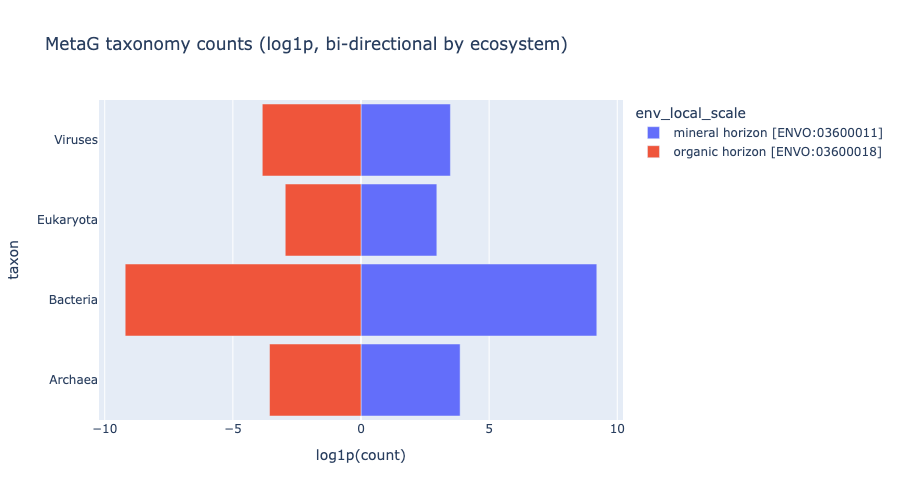

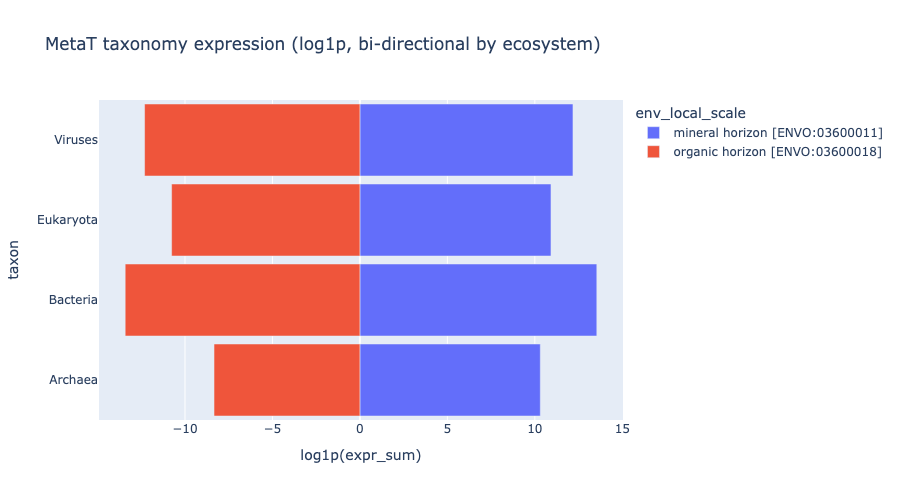

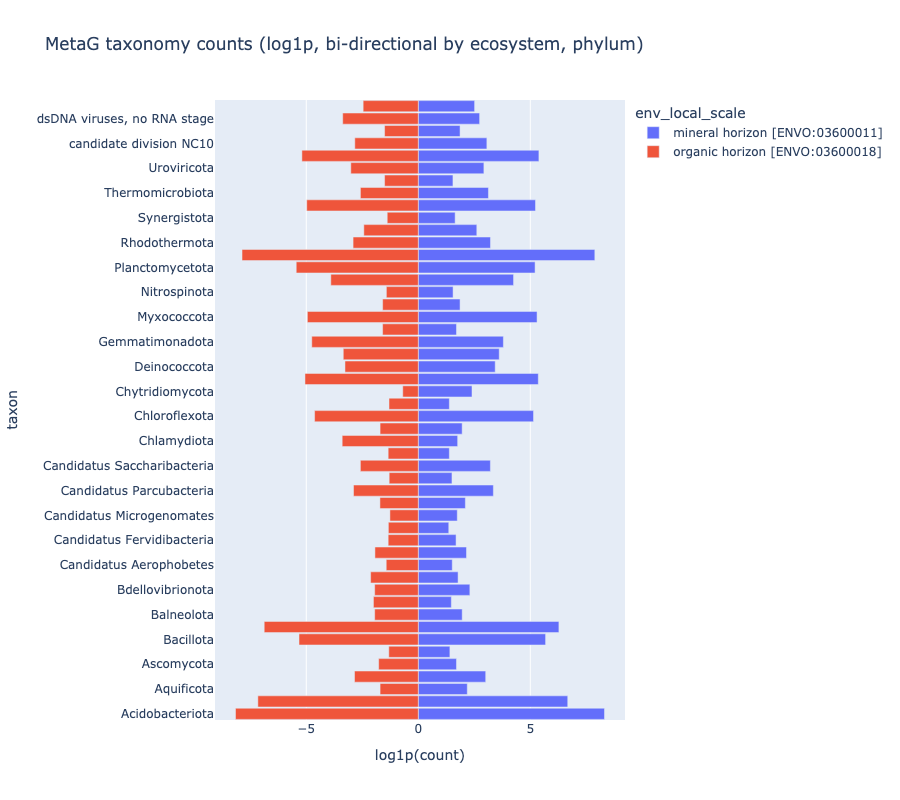

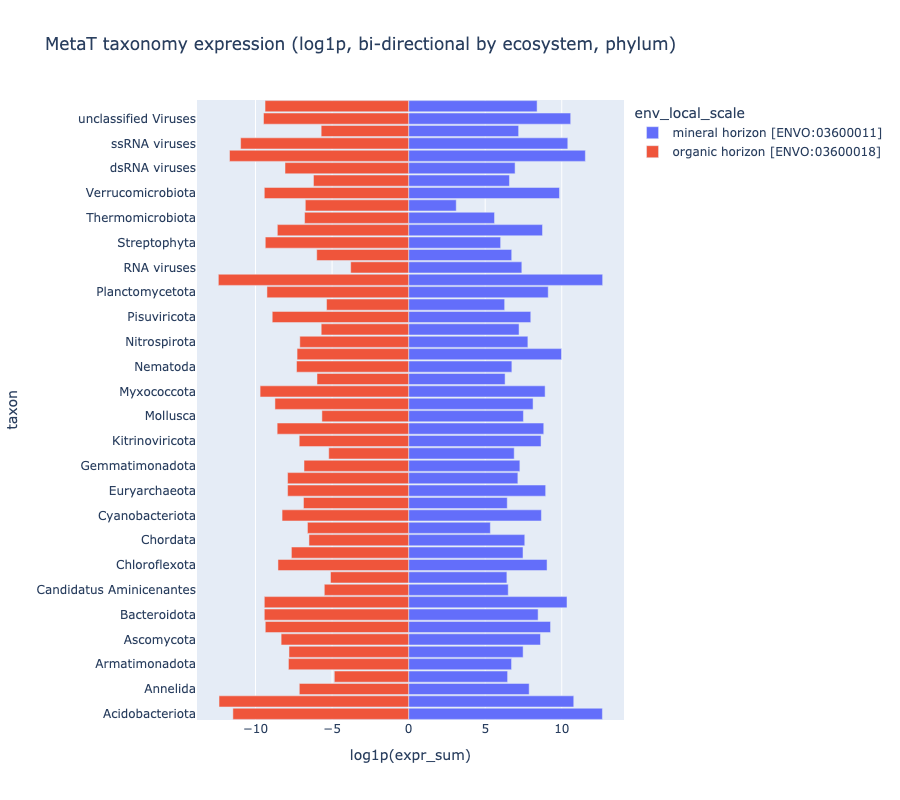

In [42]:
# Bi-directional taxonomy charts for two ecosystems
def bidir_barplot(df, value_col, title, top_n=20):
    # Expect df with columns: env_local_scale, taxon, value_col
    # Take top taxa by global sum
    top_taxa = df.groupby("taxon")[value_col].sum().sort_values(ascending=False).head(top_n).index
    sub = df[df["taxon"].isin(top_taxa)].copy()

    # Separate ecosystems
    ecos = sub["env_local_scale"].unique().tolist()
    if len(ecos) != 2:
        print(f"[INFO] Found {len(ecos)} ecosystems, expected 2. Showing normal bar chart instead.")
        fig = px.bar(sub, x=value_col, y="taxon", color="env_local_scale", barmode="group", title=title)
        return fig

    eco1, eco2 = ecos[0], ecos[1]
    sub.loc[sub["env_local_scale"] == eco2, value_col] *= -1  # flip one ecosystem
    # log1p transform before mirroring
    sub[value_col] = np.sign(sub[value_col]) * np.log1p(np.abs(sub[value_col]))

    fig = px.bar(
        sub, x=value_col, y="taxon", color="env_local_scale",
        orientation="h", title=title,
        labels={value_col: f"log1p({value_col})"}
    )
    fig.update_layout(barmode="relative", bargap=0.1)
    return fig

# kindom-level bi-directional barplots
# --- MetaG counts ---
metaG_counts_meta = metaG_counts_kingdom.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
agg_mg = metaG_counts_meta.groupby(["env_local_scale","taxon"])["count"].mean().reset_index()
fig_mg = bidir_barplot(agg_mg, "count", "MetaG taxonomy counts (log1p, bi-directional by ecosystem)")
fig_mg.write_html(os.path.join(OUTPUT_DIR, "bidir_barchart_metaG_kingdom_counts.html"), include_plotlyjs="cdn", full_html=True)
fig_mg.show(renderer="png",width=900)


# --- MetaT expression ---
metaT_expr_meta = metaT_expr_kingdom.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
agg_mt = metaT_expr_meta.groupby(["env_local_scale","taxon"])["expr_sum"].mean().reset_index()
fig_mt = bidir_barplot(agg_mt, "expr_sum", "MetaT taxonomy expression (log1p, bi-directional by ecosystem)")
fig_mt.write_html(os.path.join(OUTPUT_DIR, "bidir_barchart_metaT_kingdom_expression.html"), include_plotlyjs="cdn", full_html=True)
fig_mt.show(renderer="png",width=900)


# phylum-level bi-directional barplots
# --- MetaG counts ---
metaG_counts_meta = metaG_counts_phylum.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
agg_mg = metaG_counts_meta.groupby(["env_local_scale","taxon"])["count"].mean().reset_index()
fig_mg = bidir_barplot(agg_mg, "count", "MetaG taxonomy counts (log1p, bi-directional by ecosystem, phylum)", top_n=50)
fig_mg.write_html(os.path.join(OUTPUT_DIR, "bidir_barchart_metaG_phylum_counts.html"), include_plotlyjs="cdn", full_html=True)
fig_mg.show(renderer="png",width=900,height=800)
# --- MetaT expression ---
metaT_expr_meta = metaT_expr_phylum.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")
agg_mt = metaT_expr_meta.groupby(["env_local_scale","taxon"])["expr_sum"].mean().reset_index()
fig_mt = bidir_barplot(agg_mt, "expr_sum", "MetaT taxonomy expression (log1p, bi-directional by ecosystem, phylum)", top_n=50)
fig_mt.write_html(os.path.join(OUTPUT_DIR, "bidir_barchart_metaT_phylum_expression.html"), include_plotlyjs="cdn", full_html=True)
fig_mt.show(renderer="png",width=900,height=800)

### Kingdom level
* Both ecosystems are dominated by Bacteria, followed by smaller contributions from Archaea, Eukaryota, and Viruses.

### Phylum level
* Organic horizon: more transcriptional contribution from fungi (Ascomycota, Basidiomycota) and viruses, suggesting richer multi-kingdom interactions.

### Taxonomy Overlap Analysis

For each biosample and each taxonomic rank (e.g. kingdom, phylum, class, order, family, genus, species):
1. Parse MetaG lineage → get the set of taxa names at that rank.
2. Parse MetaT lineage → get the set of taxa names at that rank.
3. Compute:
	* n_metag_taxa = number of taxa found in MetaG at this rank
	* n_metat_taxa = number of taxa found in MetaT at this rank
	* n_shared_taxa = size of intersection
	* n_metag_only = MetaG-only taxa
	* n_metat_only = MetaT-only taxa
	* jaccard = |shared| / |union|
4. Store results in a long table
5. Visualizations:
	* Group bar (shared vs unique taxa) across ecosystme × rank
	* Heatmap (shared taxa counts or Jaccard) across biosample and box plot accross ecosystme × ranks

In [43]:
# Taxonomy overlap analysis (MetaG vs MetaT) across ranks
def taxonomy_overlap_stats(datastore, ranks=None):
    if ranks is None:
        ranks = ["kingdom","phylum","class","order","family","genus","species"]
    rows = []
    for biosample_id, items in datastore.items():
        mg_lin = parse_lineage_df(items.get("metag_lineage_results"))
        mt_lin = parse_lineage_df(items.get("metat_lineage_results"))
        for rank in ranks:
            if rank not in mg_lin.columns or rank not in mt_lin.columns:
                continue
            mg_set = set(mg_lin[rank].dropna().unique())
            mt_set = set(mt_lin[rank].dropna().unique())
            shared = mg_set & mt_set
            rows.append({
                "biosample_id": biosample_id,
                "rank": rank,
                "n_metag_taxa": len(mg_set),
                "n_metat_taxa": len(mt_set),
                "n_shared_taxa": len(shared),
                "n_metag_only": len(mg_set - mt_set),
                "n_metat_only": len(mt_set - mg_set),
                "jaccard": (len(shared) / len(mg_set | mt_set)) if (mg_set or mt_set) else float("nan")
            })
    return pd.DataFrame(rows)

tax_overlap_df = taxonomy_overlap_stats(datastore)
tax_overlap_df.to_csv(os.path.join(OUTPUT_DIR, "taxonomy_overlap_summary.csv"), index=False)
tax_overlap_df.head(20)

,biosample_id,rank,n_metag_taxa,n_metat_taxa,n_shared_taxa,n_metag_only,n_metat_only,jaccard
0,nmdc:bsm-11-042nd237,kingdom,4,4,4,0,0,1.000000
1,nmdc:bsm-11-042nd237,phylum,73,53,40,33,13,0.465116
2,nmdc:bsm-11-042nd237,class,152,107,79,73,28,0.438889
...,...,...,...,...,...,...,...,...
17,nmdc:bsm-11-622k6044,order,254,262,168,86,94,0.482759
18,nmdc:bsm-11-622k6044,family,495,463,292,203,171,0.438438
19,nmdc:bsm-11-622k6044,genus,1188,922,536,652,386,0.340534


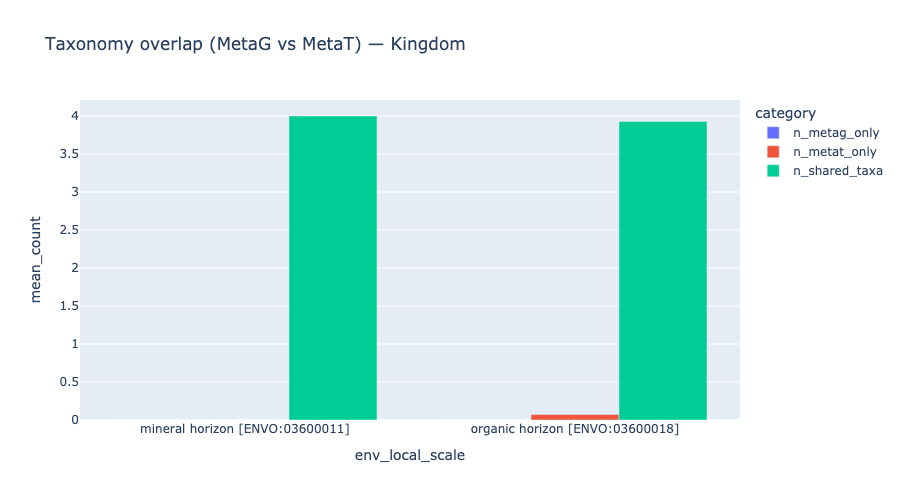

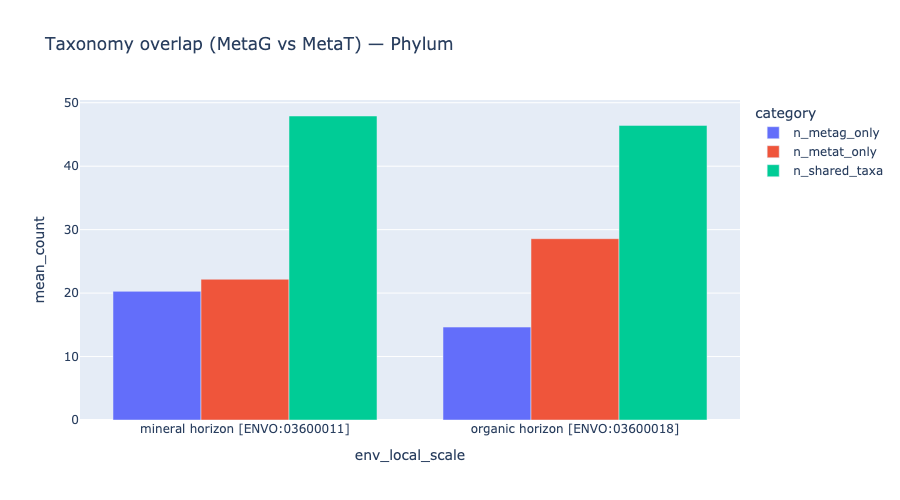

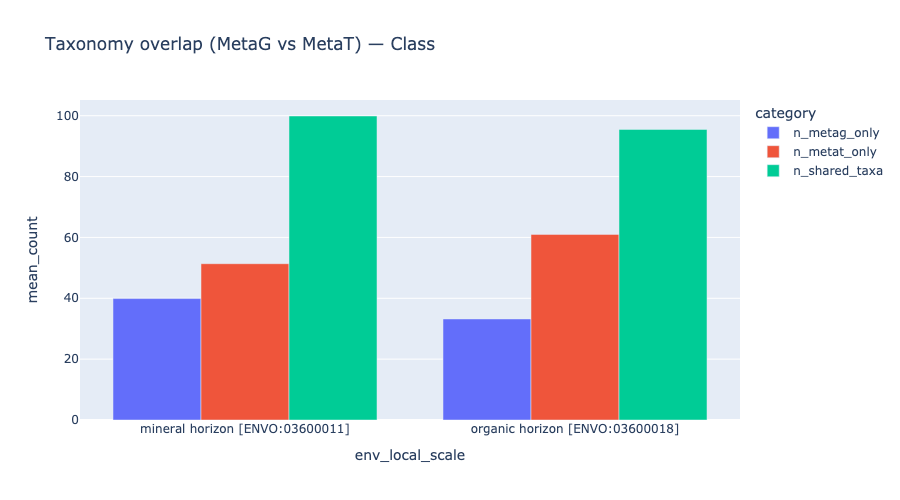

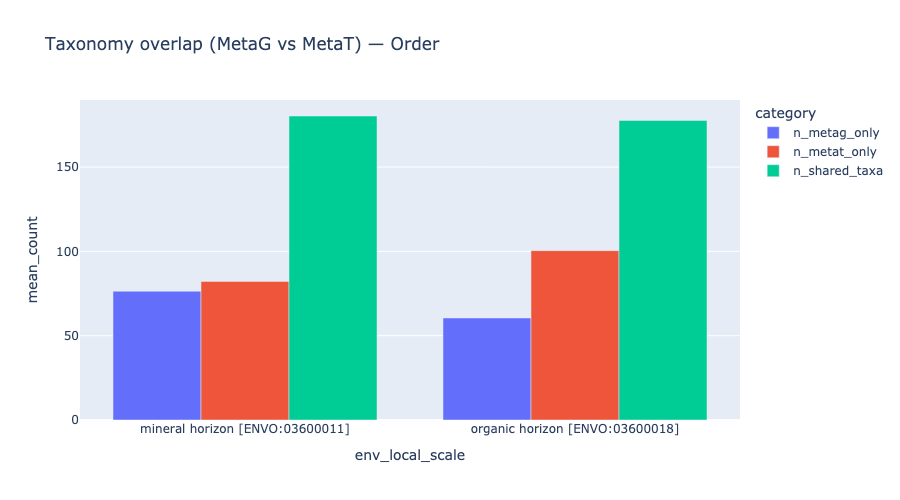

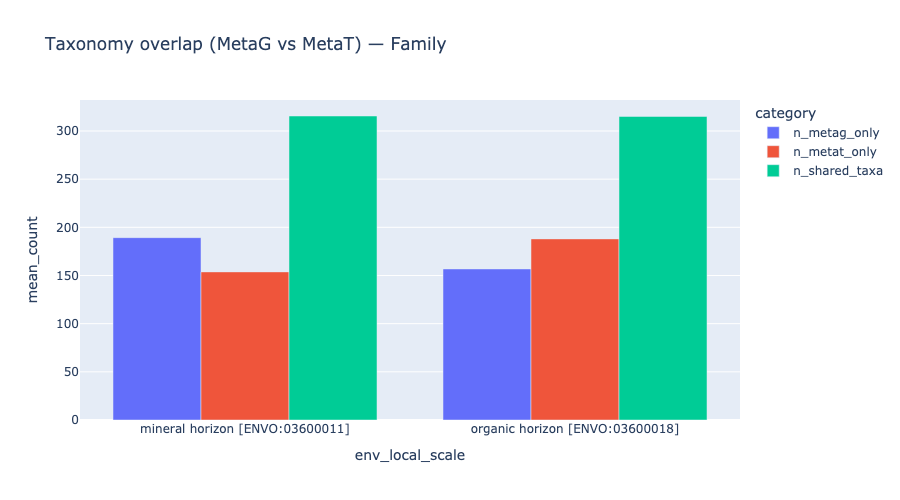

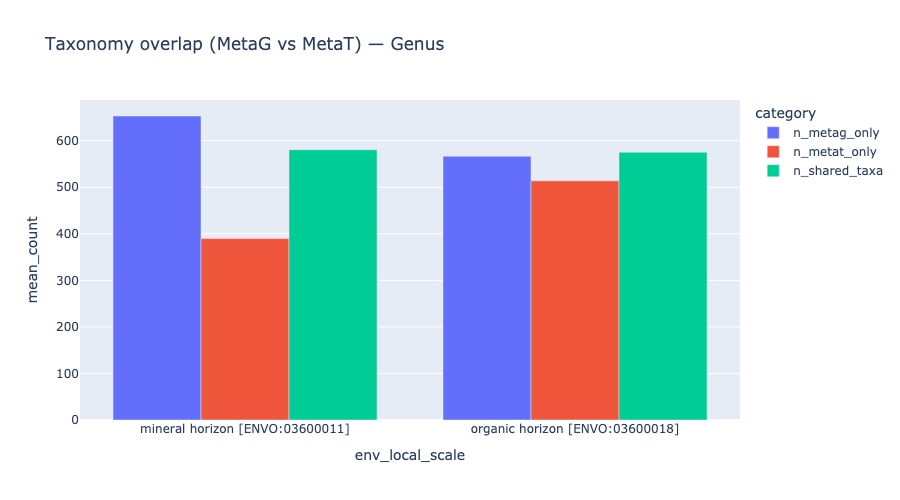

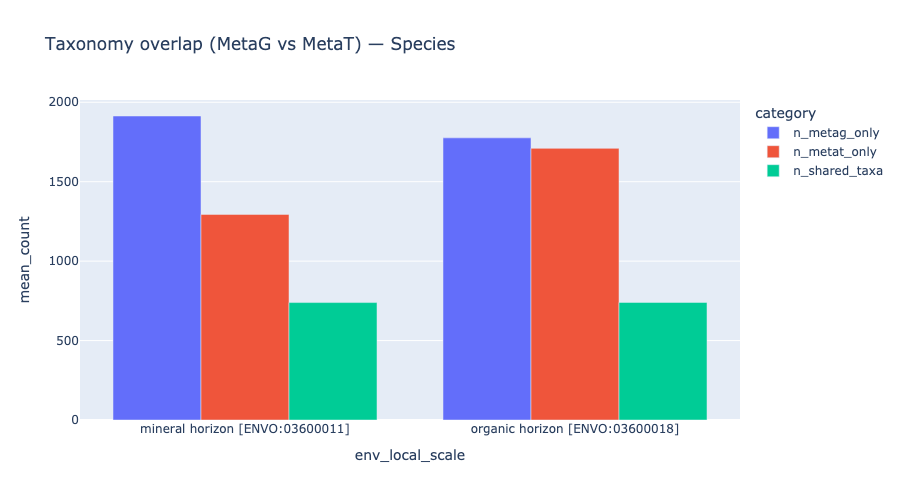

In [44]:
tax_overlap = tax_overlap_df.merge(biosample_metadata[["biosample_id","env_local_scale"]], on="biosample_id", how="left")

agg_overlap = (tax_overlap.groupby(["env_local_scale","rank"])
               [["n_shared_taxa","n_metag_only","n_metat_only"]].mean().reset_index())
rank_order = ["kingdom","phylum","class","order","family","genus","species"]
if len(agg_overlap):
    for r in rank_order:
        sub = agg_overlap[agg_overlap["rank"] == r].copy()
        if len(sub) == 0:
            continue
        df_long = sub.melt(
            id_vars=["env_local_scale"],
            value_vars=["n_metag_only","n_metat_only","n_shared_taxa"],
            var_name="category",
            value_name="mean_count"
        )
        fig = px.bar(
            df_long, x="env_local_scale", y="mean_count", color="category",
            barmode="group",
            title=f"Taxonomy overlap (MetaG vs MetaT) — {r.capitalize()}"
        )
        out_html = os.path.join(OUTPUT_DIR, f"taxonomy_overlap_barchart_{r}.html")
        fig.write_html(out_html, include_plotlyjs="cdn", full_html=True)
        fig.show(renderer="png",width=900)



* A substantial block of MetaG-only species is visible in lower ranks, larger than at higher ranks.
* Shared species are still dominant, but the DNA-only fraction suggests many species present in the community are not transcriptionally active under the sampled conditions.


* Ecosystem differences are subtle — the balance of shared vs unique taxa is broadly consistent between mineral horizons and organic horizons


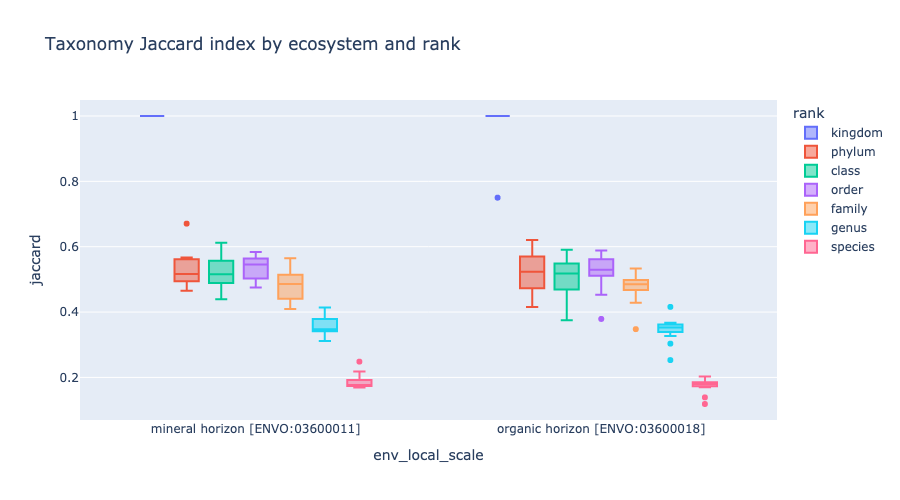

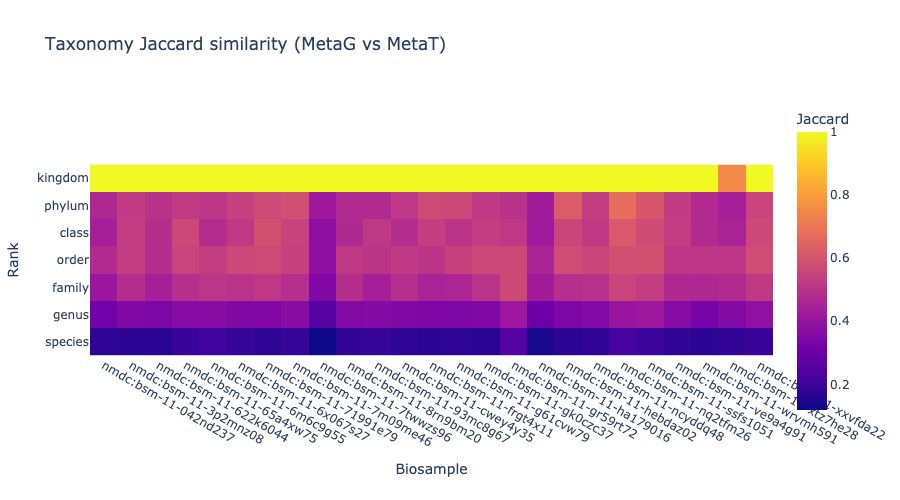

In [45]:


tax_with_meta = tax_overlap_df.merge(biosample_metadata[["biosample_id", "env_local_scale"]], on="biosample_id", how="left")
# Taxonomy overlap differences across ecosystems
if len(tax_with_meta):
    fig1 = px.box(tax_with_meta, x="env_local_scale", y="jaccard", color="rank",
                  title="Taxonomy Jaccard index by ecosystem and rank")
    fig1.write_html(os.path.join(OUTPUT_DIR, "taxonomy_jaccard_boxplot.html"), include_plotlyjs="cdn", full_html=True)
    fig1.show(renderer="png",width=900)  # use renderer="png" to show in some environments
   
# Heatmap of Jaccard index (biosample × rank)
if len(tax_overlap_df):
    mat = tax_overlap_df.pivot(index="rank", columns="biosample_id", values="jaccard")
    # Reindex rows using the requested order (keep only ranks that appear)
    present_ranks = [r for r in rank_order if r in mat.index]
    mat = mat.reindex(present_ranks)
    fig2 = px.imshow(mat, labels=dict(x="Biosample", y="Rank", color="Jaccard"),
                     title="Taxonomy Jaccard similarity (MetaG vs MetaT)")
    fig2.write_html(os.path.join(OUTPUT_DIR, "taxonomy_overlap_jaccard_heatmap.html"), include_plotlyjs="cdn", full_html=True)
    fig2.show(renderer="png",width=900)


* Ecological implication: Microbial communities maintain a stable backbone of active higher taxa, but at the species level, functional activity is more selective and dynamic, likely reflecting fine-scale ecological filtering.
* Many reads that cannot be confidently assigned to species or genus are “backed up” to order or family, where annotation is more reliable.
* At species level, fine-scale ecological filtering (e.g., niche partitioning, dormancy, stress tolerance) kicks in, so only a subset of species are transcribing, dropping overlap.